In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pickle

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 19 13:22:00 2017
@author: cli
"""

import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from functools import reduce

class sample_GMM():
    """ Toy dataset containing points sampled from a gaussian mixture distribution.
    The dataset contains 3 sources:
    * samples
    * labels
    * densities
    """
    def __init__(self,
                 num_examples,
                 means=None,
                 variances=None,
                 priors=None,
                 **kwargs):
        rng = kwargs.pop('rng', None)
        if rng is None:
            seed = kwargs.pop('seed', 0)
            rng = np.random.RandomState(seed)

        gaussian_mixture = GMM_distribution(means=means,
                                            variances=variances,
                                            priors=priors,
                                            rng=rng)
        self.means = gaussian_mixture.means
        self.variances = gaussian_mixture.variances
        self.priors = gaussian_mixture.priors

        features, labels = gaussian_mixture.sample(nsamples=num_examples)
        densities = gaussian_mixture.pdf(x=features)

        data = {'samples': features, 'labels': labels, 'density': densities}

        self.data = data

In [3]:
class GMM_distribution(object):
    """ Gaussian Mixture Distribution
    Parameters
    ----------
    means : tuple of ndarray.
       Specifies the means for the gaussian components.
    variances : tuple of ndarray.
       Specifies the variances for the gaussian components.
    priors : tuple of ndarray
       Specifies the prior distribution of the components.
    """
    def __init__(self,
                 means=None,
                 variances=None,
                 priors=None,
                 rng=None,
                 seed=None):

        if means is None:
            means = map(lambda x: 10.0 * np.array(x),
                        [[0, 0], [1, 1], [-1, -1], [1, -1], [-1, 1]])
        # Number of components
        self.ncomponents = len(means)
        self.dim = means[0].shape[0]
        self.means = means
        # If prior is not specified let prior be flat.
        if priors is None:
            priors = [1.0 / self.ncomponents for _ in range(self.ncomponents)]
        self.priors = priors
        # If variances are not specified let variances be identity
        if variances is None:
            variances = [np.eye(self.dim) for _ in range(self.ncomponents)]
        self.variances = variances

        assert len(means) == len(variances), "Mean variances mismatch"
        assert len(variances) == len(priors), "prior mismatch"

        if rng is None:
            rng = npr.RandomState(seed=seed)
        self.rng = rng

    def _sample_prior(self, nsamples):
        return self.rng.choice(a=self.ncomponents,
                               size=(nsamples, ),
                               replace=True,
                               p=self.priors)

    def sample(self, nsamples):
        # Sampling priors
        samples = []
        fathers = self._sample_prior(nsamples=nsamples).tolist()
        for father in fathers:
            samples.append(
                self._sample_gaussian(self.means[father],
                                      self.variances[father]))
        return np.array(samples), np.array(fathers)

    def _sample_gaussian(self, mean, variance):
        # sampling unit gaussians
        epsilons = self.rng.normal(size=(self.dim, ))

        return mean + np.linalg.cholesky(variance).dot(epsilons)

    def _gaussian_pdf(self, x, mean, variance):
        return multivariate_normal.pdf(x, mean=mean, cov=variance)

    def pdf(self, x):
        "Evaluates the the probability density function at the given point x"
        pdfs = map(lambda m, v, p: p * self._gaussian_pdf(x, m, v), self.means,
                   self.variances, self.priors)
        return reduce(lambda x, y: x + y, pdfs, 0.0)

In [4]:
def plot_GMM(dataset, save_path):
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
    ax = axes
    ax.set_aspect('equal')
#     ax.set_xlim(-3, 3)
#     ax.set_ylim(-3.5, 3.5)
    # ax.set_xlim([-6, 6])
    # ax.set_ylim([-6, 6])
    # ax.set_xticks([-6, -4, -2, 0, 2, 4, 6])
    # ax.set_yticks([-6, -4, -2, 0, 2, 4, 6])
    # ax.set_xlabel('$x_1$')
    # ax.set_ylabel('$x_2$')
    ax.axis('on')

    ax.set_title('GMM')

    x = dataset.data['samples']
    targets = dataset.data['labels']

    axes.scatter(x[:, 0],
                 x[:, 1],
                 marker='.',
                 c=cm.Set1(targets.astype(float) / 2.0 / 2.0),
                 alpha=0.3)
    plt.tight_layout()
#     plt.savefig(save_path, transparent=True, bbox_inches='tight')
    plt.show()

# Generate Gaussian mixture data

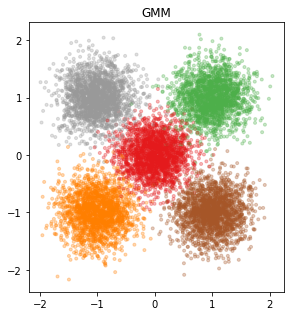

In [5]:
if __name__ == '__main__':
    means = map(lambda x: np.array(x),
                [[0, 0], [1, 1], [-1, -1], [1, -1], [-1, 1]])
#     means = map(lambda x: np.array(x),
#                 [[0, 0], [0.1, 0.1], [-0.1, -0.1], [0.1, -0.1], [-0.1, 0.1]])
    
    means = list(means)
    std = 0.1
    variances = [np.eye(2) * std for _ in means]

    priors = [1.0 / len(means) for _ in means]

    gaussian_mixture = GMM_distribution(means=list(means),
                                        variances=variances,
                                        priors=priors)
    dataset = sample_GMM(10000,
                         means,
                         variances,
                         priors,
                         sources=('features', ))
    save_path = './gmm_data.pdf'
    plot_GMM(dataset, save_path)

In [6]:
dataset.data['samples'].shape

(10000, 2)

In [7]:
dataset.data['labels'].shape

(10000,)

In [8]:
dataset.data['density'].shape

(10000,)

In [9]:
with open('gmm_data.pkl', 'wb') as f:
    pickle.dump(dataset, f)

# Gaussian mixture components

In [10]:
gm = GaussianMixture(n_components=5, random_state=0).fit(dataset.data['samples'])
gm.means_

array([[-0.00158645, -0.00121417],
       [-1.00028501, -0.99883785],
       [ 0.99765547,  1.00428649],
       [ 0.99835097, -1.00022001],
       [-1.00791161,  0.99809341]])

In [11]:
gm.predict([[0, 0], [12, 3]])

array([0, 2])

In [12]:
gm.covariances_

array([[[ 0.10034795,  0.00110681],
        [ 0.00110681,  0.09360854]],

       [[ 0.1007576 , -0.00101381],
        [-0.00101381,  0.10196022]],

       [[ 0.10557505,  0.00325545],
        [ 0.00325545,  0.09776657]],

       [[ 0.09804622,  0.00381798],
        [ 0.00381798,  0.09504477]],

       [[ 0.09589455,  0.00124414],
        [ 0.00124414,  0.09975391]]])